In [2]:
import pandas as pd
import os

def load_calisp_data(filename, filter=True):
    
    # (1) load files
    if os.path.isdir(filename):
        file_data = []
        for f in os.listdir(filename):
            f = os.path.join(filename, f)
            file_data.append(pd.read_feather(f))
        data = pd.concat(file_data)
    else:
        data = pd.read_feather(filename)
    original_len = len(data.index)
    
    # (2) filter data
    if filter:
        original_len = len(data.index)
        data = data.loc[lambda df: (df['flag_peptide_contains_sulfur'] == False) &
                        (df['flag_peptide_has_modifications'] == False) &
                        (df['flag_spectrum_is_wobbly'] == False) &
                        (df['flag_psm_has_low_confidence'] == False) &
                        (df['flag_psm_is_ambiguous'] == False) &
                        (df['flag_spectrum_is_contaminated'] == False) &
                        (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
    print (f'Loaded {original_len} spectra from file(s). {len(data.index)}'
           f'({len(data.index)/original_len*100:.1f}%) remaining after filters.')

    # (3) calculate deltas
    data["delta_na"] = (data["ratio_na"] / (0.011056585166521 / 0.988943414833479)-1)*1000
    data["delta_fft"] = (data["ratio_fft"] / (0.011056585166521 / 0.988943414833479)-1)*1000
    
    return data
        

In [3]:
# analyze_by_file should be 'experiment' for PSM files or 'ms_run' for mzml files, or left out (to analyze everything
# together)

def benchmark(data, analyze_by_file=''):
    
    irms_benchmark_txt = 'ATN=-23.8 CRH=-30.8 CV=-25.7 Cup=-25 K12=-24.5 HOMO=-20.3 Ne1=-47.8 Nu1=-39.9 NV=-37.4 '\
                         'Nm1=-45.9 PaD=-21.2 PD=-19.6 Pfl=-24.6 KF7=-25.7 841=-24.6 VF=-24 LT2=-24.6 259=-23.6 '\
                         '137=-24.1 SMS=-24.1 HB2=-20.9'
    
    benchmarking = pd.DataFrame(columns=['file', 'bin', 'IRMS', '#spectra', 'NA', 'FFT'])
    for benchmark in irms_benchmark_txt.split():
        key, value = benchmark.split('=')
        value = float(value)
        subdata = data[data['bins'] == key]
        if len(analyze_by_file):
            files = subdata[analyze_by_file].unique()
            for f in files:
                file_subdata = data[data[analyze_by_file] == f]
                benchmarking.loc[len(benchmarking.index)] = [f, key, value, len(file_subdata.index),
                                                             file_subdata['delta_na'].median(), 
                                                             file_subdata['delta_fft'].median()]
                
        else:
            benchmarking.loc[len(benchmarking.index)] = ['', key, value, len(subdata.index),
                                                         subdata['delta_na'].median(), subdata['delta_fft'].median()]

    benchmarking['offset_NA'] = benchmarking['NA'] - benchmarking['IRMS']
    benchmarking['offset_FFT'] = benchmarking['FFT'] - benchmarking['IRMS']
                                         
    offset_na = benchmarking['offset_NA'].mean()
    offset_fft = benchmarking['offset_FFT'].mean()

    benchmarking['error_NA'] = abs(benchmarking['IRMS'] - (benchmarking['NA'] - offset_na))
    benchmarking['error_FFT'] = abs(benchmarking['IRMS'] - (benchmarking['FFT'] - offset_fft))
    
    return benchmarking
                                         

In [3]:
def analyze_by_flag(data, analyze_by_file=''):
    flags = 'flag_peptide_contains_sulfur flag_peptide_has_modifications flag_peptide_assigned_to_multiple_proteins '\
           'flag_psm_has_low_confidence flag_psm_is_ambiguous flag_spectrum_is_contaminated flag_spectrum_is_wobbly '\
           'flag_peak_at_minus_one_pos'
    
    analysis = pd.DataFrame(columns=['flag', '#spectra', 'fraction', 'ss_FFT', 'mean_error_NA', 'mean_error_FFT'])
    for flag in flags.split():
        subdata = data.loc[lambda df: df[flag] == True, :]
        benchmarking = benchmark(subdata, analyze_by_file)
        analysis.loc[len(analysis.index)] = [flag, len(subdata.index), len(subdata.index)/len(data.index),
                                             subdata['error_fft'].mean(), benchmarking['error_NA'].mean(),
                                             benchmarking['error_FFT'].mean()]
    
    subdata = data.copy(deep=False)
    for flag in flags.split():
        subdata = subdata.loc[lambda df: df[flag] == False, :]
    benchmarking = benchmark(subdata, analyze_by_file)
    analysis.loc[len(analysis.index)] = ['clean', len(subdata.index), len(subdata.index)/len(data.index),
                                         subdata['error_fft'].mean(), benchmarking['error_NA'].mean(),
                                         benchmarking['error_FFT'].mean()]
    return analysis


In [4]:
# benchmarking step 1
# using data from single organisms with 13C determined by IRMS:
data = load_calisp_data('/home/kinestetika/Proteomics/sif/calisp/', filter = False)
# performance of flags
analysis = analyze_by_flag(data, analyze_by_file='experiment')
analysis.style #requires installation of python module "jinja2"

# column "ss_FFT" shows that the goodness of FFT fit is especially low for "flag_psm_has_low_confidence",
# "flag_psm_is_ambiguous", "flag_spectrum_is_contaminated" and "flag_spectrum_is_wobbly".
# "Clean" has the best performance, it contains those spectra for which no flags were raised at all.
# Worse performance of small batches of spectra is to be expected.
# Metrics of "flag_peptide_contains_sulfur" and "flag_peptide_has_modifications" is surprisinglt poor

Loaded 9696072 spectra from file(s). 9696072(100.0%) remaining after filters.


,flag,#spectra,fraction,ss_FFT,mean_error_NA,mean_error_FFT
0,flag_peptide_contains_sulfur,4124599,0.425389,0.012327,8.987012,32.429301
1,flag_peptide_has_modifications,2425725,0.250176,0.012169,6.089749,34.281976
2,flag_peptide_assigned_to_multiple_proteins,368864,0.038043,0.008348,11.484724,19.647521
3,flag_psm_has_low_confidence,591896,0.061045,0.014594,22.972210,27.414203
4,flag_psm_is_ambiguous,452649,0.046684,0.014565,13.720200,41.934243
5,flag_spectrum_is_contaminated,341598,0.035231,0.021630,17.852976,41.543707
6,flag_spectrum_is_wobbly,984713,0.101558,0.014911,9.291975,32.632073
7,flag_peak_at_minus_one_pos,1861152,0.191949,0.012666,5.421952,18.029772
8,clean,3738951,0.385615,0.010208,5.017111,16.239315


In [5]:
# benchmarking step 2
# using data from mock communities with 13C determined by IRMS:
data = load_calisp_data('/home/kinestetika/Proteomics/mock-community/Run1_All/calisp/', filter = False)
data = data.loc[lambda df: df['flag_peptide_assigned_to_multiple_bins'] == False, :]
# performance of flags
analysis = analyze_by_flag(data, analyze_by_file='')
analysis.style #requires installation of python module "jinja2"

# community results closely mirror results for pure cultures. 
# Decided to filter out rows 0, 1, 3-6 by default in load_calisp_data with filters activated

Loaded 5149648 spectra from file(s). 5149648(100.0%) remaining after filters.


,flag,#spectra,fraction,ss_FFT,mean_error_NA,mean_error_FFT
0,flag_peptide_contains_sulfur,1426966,0.323455,0.012504,19.211786,30.829580
1,flag_peptide_has_modifications,1312843,0.297586,0.012300,18.392316,27.104828
2,flag_peptide_assigned_to_multiple_proteins,37527,0.008506,0.010325,167.435807,481.518689
3,flag_psm_has_low_confidence,379060,0.085923,0.015651,20.498624,25.441786
4,flag_psm_is_ambiguous,312075,0.070739,0.014087,27.004874,34.341294
5,flag_spectrum_is_contaminated,165292,0.037467,0.020418,54.423776,64.339680
6,flag_spectrum_is_wobbly,509296,0.115444,0.014209,13.507609,25.885716
7,flag_peak_at_minus_one_pos,1052281,0.238524,0.013362,16.394340,18.257779
8,clean,1779984,0.403474,0.011224,15.290746,17.841187


In [4]:
# benchmarking step 3
# using data from single organisms with 13C determined by IRMS and from mock communities with 13C determined by IRMS,
# determine optimum threshold for FFT fit:

data1 = load_calisp_data('/home/kinestetika/Proteomics/sif/calisp/')
data2 = load_calisp_data('/home/kinestetika/Proteomics/mock-community/Run1_All/calisp/')

thresholds = [1, 0.1, 0.01, 0.001, 0.0001, 0.00005, 0.000025, 0.000001]

pure_culture_n = []
pure_culture_error = []
threshold_benchmarks = pd.DataFrame(columns=['threshold', 'pure_culture_n', 'community_n', 'pure_culture_error', 
                                            'community_error'])

for t in thresholds:
    subdata1 = data1.loc[lambda df: (df['error_fft'] < t), :]
    subdata2 = data2.loc[lambda df: (df['error_fft'] < t), :]
    benchmarks1 = benchmark(subdata1, analyze_by_file='experiment')
    benchmarks2 = benchmark(subdata2, analyze_by_file='')
    threshold_benchmarks.loc[len(threshold_benchmarks.index)] = [t, len(subdata1.index), len(subdata2.index),
                                                                benchmarks1["error_FFT"].mean(),
                                                                benchmarks2["error_FFT"].mean()]
pd.set_option('precision', 6)
threshold_benchmarks.style

# We can see that 0.001 (row 3) is a reasonable compromise between accuracy and sensitivity as a threshold
# for the FFT fit

Loaded 9696072 spectra from file(s). 4690723(48.4%) remaining after filters.
Loaded 5149648 spectra from file(s). 2311271(44.9%) remaining after filters.


,threshold,pure_culture_n,community_n,pure_culture_error,community_error
0,1.000000,4690723.000000,2311271.000000,14.341147,18.375613
1,0.100000,4633418.000000,2288691.000000,13.838072,17.815604
2,0.010000,3456740.000000,1580488.000000,4.497889,8.510611
3,0.001000,1866088.000000,669794.000000,2.788847,4.993302
4,0.000100,517840.000000,132004.000000,2.475197,5.632583
5,0.000050,301448.000000,69180.000000,2.354824,7.062312
6,0.000025,163333.000000,34007.000000,2.201848,7.839464
7,0.000001,4210.000000,845.000000,4.386165,18.437235


In [5]:
# benchmarking step 4
# Once we filter for FFT fit, does it still make sense to apply the other filters?

data1 = load_calisp_data('/home/kinestetika/Proteomics/sif/calisp/', filter=False)
data1 = data1.loc[lambda df: (df['flag_peptide_assigned_to_multiple_bins'] == False), :]

data2 = load_calisp_data('/home/kinestetika/Proteomics/mock-community/Run1_All/calisp/', filter = False)
data2 = data2.loc[lambda df: (df['flag_peptide_assigned_to_multiple_bins'] == False), :]

thresholds = [1, 0.1, 0.01, 0.001, 0.0001, 0.00005, 0.000025, 0.000001]

pure_culture_n = []
pure_culture_error = []
threshold_benchmarks = pd.DataFrame(columns=['threshold', 'pure_culture_n', 'community_n', 'pure_culture_error', 
                                            'community_error'])

for t in thresholds:
    subdata1 = data1.loc[lambda df: (df['error_fft'] < t), :]
    subdata2 = data2.loc[lambda df: (df['error_fft'] < t), :]
    benchmarks1 = benchmark(subdata1, analyze_by_file='experiment')
    benchmarks2 = benchmark(subdata2, analyze_by_file='')
    threshold_benchmarks.loc[len(threshold_benchmarks.index)] = [t, len(subdata1.index), len(subdata2.index),
                                                                benchmarks1["error_FFT"].mean(),
                                                                benchmarks2["error_FFT"].mean()]
pd.set_option('precision', 6)
threshold_benchmarks.style

# The results actually become better if we do not apply the semantic filters

Loaded 9696072 spectra from file(s). 9696072(100.0%) remaining after filters.
Loaded 5149648 spectra from file(s). 5149648(100.0%) remaining after filters.


,threshold,pure_culture_n,community_n,pure_culture_error,community_error
0,1.000000,9696072.000000,4411640.000000,20.461214,18.037359
1,0.100000,9564222.000000,4363546.000000,19.659165,17.384978
2,0.010000,6715244.000000,2883164.000000,5.629416,4.789234
3,0.001000,3132596.000000,1088438.000000,2.956198,2.387259
4,0.000100,736276.000000,194361.000000,2.404428,3.015861
5,0.000050,411774.000000,99884.000000,2.257095,4.187177
6,0.000025,215449.000000,48553.000000,2.137136,5.967155
7,0.000001,5334.000000,1214.000000,4.965960,14.371083


In [8]:
# benchmarking step 5
# using data from single organisms with 13C determined by IRMS and from mock communities with 13C determined by IRMS,
# determine if subsampling spectra across a range of charges actually makes sense, or that it is better just to use
# the charge of the associated psm

data1 = load_calisp_data('/home/kinestetika/Proteomics/sif/calisp/', filter=False)
data1 = data1.loc[lambda df: (df['error_fft'] < 0.001), :]
data1 = data1.loc[lambda df: (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
data2 = load_calisp_data('/home/kinestetika/Proteomics/mock-community/Run1_All/calisp/', filter=False)
data2 = data2.loc[lambda df: (df['error_fft'] < 0.001), :]
data2 = data2.loc[lambda df: (df['flag_peptide_assigned_to_multiple_bins'] == False), :]

charge_benchmarks = pd.DataFrame(columns=['charge', 'pure_culture_n', 'community_n', 'pure_culture_error', 
                                            'community_error'])

data1_single_charge = data1.loc[lambda df: (df['psm_charge'] == df['spectrum_charge']), :]
data2_single_charge = data2.loc[lambda df: (df['psm_charge'] == df['spectrum_charge']), :]

benchmarks1 = benchmark(data1, analyze_by_file='experiment')
benchmarks1sc = benchmark(data1_single_charge, analyze_by_file='experiment')
benchmarks2 = benchmark(data2, analyze_by_file='')
benchmarks2sc = benchmark(data2_single_charge, analyze_by_file='')

charge_benchmarks.loc[0] = ['all', len(data1.index), len(data2.index), benchmarks1["error_FFT"].mean(),
                           benchmarks2["error_FFT"].mean()]
charge_benchmarks.loc[1] = ['psm', len(data1_single_charge.index), len(data2_single_charge.index),
                           benchmarks1sc["error_FFT"].mean(), benchmarks2sc["error_FFT"].mean()]

pd.set_option('precision', 1)
charge_benchmarks.style

# Sampling across charges is slightly better, but relatively few extra spectra are picked up and the difference may
# not be significant

Loaded 9696072 spectra from file(s). 9696072(100.0%) remaining after filters.
Loaded 5149648 spectra from file(s). 5149648(100.0%) remaining after filters.


,charge,pure_culture_n,community_n,pure_culture_error,community_error
0,all,3132596,1088438,3.0,2.4
1,psm,2735803,982121,3.1,3.0


In [1]:
# Let's create a new load function that builds in the benchmarking outcomes:
import pandas as pd
import os

def load_calisp_data(filename, target):
    
    # (1) load files
    if os.path.isdir(filename):
        file_data = []
        for f in os.listdir(filename):
            f = os.path.join(filename, f)
            file_data.append(pd.read_feather(f))
        data = pd.concat(file_data)
    else:
        data = pd.read_feather(filename)
    original_len = len(data.index)
    
    # (2) filter data
    original_len = len(data.index)
    if target.lower() == 'na':
        data = data.loc[lambda df: (df['flag_peptide_contains_sulfur'] == False) &
                        (df['flag_peptide_has_modifications'] == False) &
                        (df['flag_spectrum_is_wobbly'] == False) &
                        (df['flag_psm_has_low_confidence'] == False) &
                        (df['flag_psm_is_ambiguous'] == False) &
                        (df['flag_spectrum_is_contaminated'] == False) &
                        (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
    elif target.lower() == 'fft':
        data = data.loc[lambda df: (df['error_fft'] < 0.001) &
                        (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
        
    print (f'Loaded {original_len} spectra from file(s). {len(data.index)}'
           f'({len(data.index)/original_len*100:.1f}%) remaining after filters.')

    # (3) calculate deltas
    data["delta_na"] = (data["ratio_na"] / (0.011056585166521 / 0.988943414833479)-1)*1000
    data["delta_fft"] = (data["ratio_fft"] / (0.011056585166521 / 0.988943414833479)-1)*1000
    
    return data

In [2]:
# Let's create a new benchmarking function that builds in the outcomes:

def benchmark(data_na, data_fft, analyze_by_file=''):
    
    irms_benchmark_txt = 'ATN=-23.8 CRH=-30.8 CV=-25.7 Cup=-25 K12=-24.5 HOMO=-20.3 Ne1=-47.8 Nu1=-39.9 NV=-37.4 '\
                         'Nm1=-45.9 PaD=-21.2 PD=-19.6 Pfl=-24.6 KF7=-25.7 841=-24.6 VF=-24 LT2=-24.6 259=-23.6 '\
                         '137=-24.1 SMS=-24.1 HB2=-20.9'
    
    benchmarking = pd.DataFrame(columns=['file', 'bin', 'IRMS', '#spectra NA', 'NA', '#spectra FFT', 'FFT'])
    for benchmark in irms_benchmark_txt.split():
        key, value = benchmark.split('=')
        value = float(value)
        subdata_na = data_na.loc[lambda df: (df['bins'] == key), :]
        subdata_fft = data_fft.loc[lambda df: (df['bins'] == key), :]
        if len(analyze_by_file):
            files = subdata_na[analyze_by_file].unique()
            for f in files:
                file_subdata_na = subdata_na.loc[lambda df: (df[analyze_by_file] == f), :]
                file_subdata_fft = subdata_fft.loc[lambda df: (df[analyze_by_file] == f), :]
                
                benchmarking.loc[len(benchmarking.index)] = [f, key, value, len(file_subdata_na.index),
                                                             file_subdata_na['delta_na'].median(),
                                                             len(file_subdata_fft.index),
                                                             file_subdata_fft['delta_fft'].median()]
                
        else:
            benchmarking.loc[len(benchmarking.index)] = ['', key, value, 
                                                         len(subdata_na.index), subdata_na['delta_na'].median(), 
                                                         len(subdata_fft.index), subdata_fft['delta_fft'].median()]

    benchmarking['offset_NA'] = benchmarking['NA'] - benchmarking['IRMS']
    benchmarking['offset_FFT'] = benchmarking['FFT'] - benchmarking['IRMS']
                                         
    offset_na = benchmarking['offset_NA'].mean()
    offset_fft = benchmarking['offset_FFT'].mean()

    benchmarking['error_NA'] = abs(benchmarking['IRMS'] - (benchmarking['NA'] - offset_na))
    benchmarking['error_FFT'] = abs(benchmarking['IRMS'] - (benchmarking['FFT'] - offset_fft))
    
    return benchmarking
                                         

In [3]:
%matplotlib inline
import matplotlib.pyplot as plot

In [4]:
# final benchmarks pure culture data

data1na = load_calisp_data('/home/kinestetika/Proteomics/sif/calisp/', target='na')
data1fft = load_calisp_data('/home/kinestetika/Proteomics/sif/calisp/', target='fft')
benchmarks1 = benchmark(data1na, data1fft, analyze_by_file='experiment')
print(f'pure culture offset (na, fft) {benchmarks1["offset_NA"].mean():.1f}, {benchmarks1["offset_FFT"].mean():.1f}')
print(f'pure culture error (na, fft) {benchmarks1["error_NA"].mean():.1f}, {benchmarks1["error_FFT"].mean():.1f}')

pd.set_option('precision', 1)
benchmarks1.style


Loaded 9696072 spectra from file(s). 4690723(48.4%) remaining after filters.
Loaded 9696072 spectra from file(s). 3132596(32.3%) remaining after filters.
pure culture offset (na, fft) -34.0, -31.6
pure culture error (na, fft) 3.4, 3.0


,file,bin,IRMS,#spectra NA,NA,#spectra FFT,FFT,offset_NA,offset_FFT,error_NA,error_FFT
0,ATN_2000ng_TargetPeptideSpectrumMatch.txt,ATN,-23.8,206732,-54.1,128658,-53.7,-30.3,-29.9,3.7,1.7
1,CRH_904ng_TargetPeptideSpectrumMatch.txt,CRH,-30.8,76188,-64.7,55764,-64.7,-33.9,-33.9,0.1,2.3
2,Run3_CV_TargetPeptideSpectrumMatch.txt,CV,-25.7,148050,-58.6,100499,-56.0,-32.9,-30.3,1.0,1.3
3,CV_2000ng_TargetPeptideSpectrumMatch.txt,CV,-25.7,154055,-58.2,108693,-57.7,-32.5,-32.0,1.4,0.4
4,Cup_2000ng_TargetPeptideSpectrumMatch.txt,Cup,-25.0,213678,-54.6,146579,-55.2,-29.6,-30.2,4.4,1.4
5,Run3_91_TargetPeptideSpectrumMatch.txt,K12,-24.5,179452,-62.1,112632,-54.5,-37.6,-30.0,3.6,1.6
6,MKH_460min_2700ng_TargetPeptideSpectrumMatch.txt,HOMO,-20.3,64151,-50.0,69049,-52.1,-29.7,-31.8,4.2,0.2
7,MKH_260min_1800ng_TargetPeptideSpectrumMatch.txt,HOMO,-20.3,49476,-48.0,50325,-50.0,-27.7,-29.7,6.2,1.9
8,Run2_MKH_140min_Standard_900ng_TargetPeptideSpectrumMatch.txt,HOMO,-20.3,25322,-53.3,20193,-50.2,-33.0,-29.9,0.9,1.7
9,Run2_Ne1-B_182ng_TargetPeptideSpectrumMatch.txt,Ne1,-47.8,140132,-84.1,88285,-75.4,-36.3,-27.6,2.3,4.1


<AxesSubplot:xlabel='IRMS', ylabel='NA'>

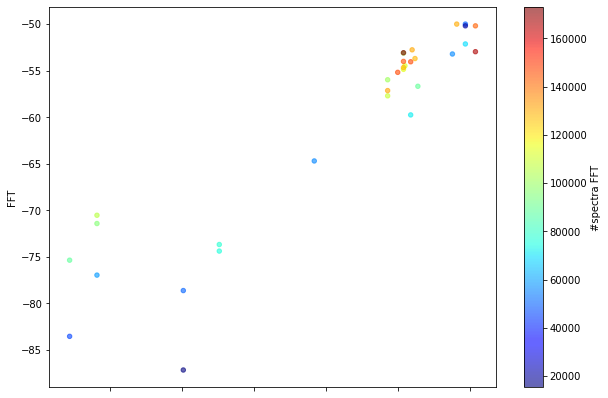

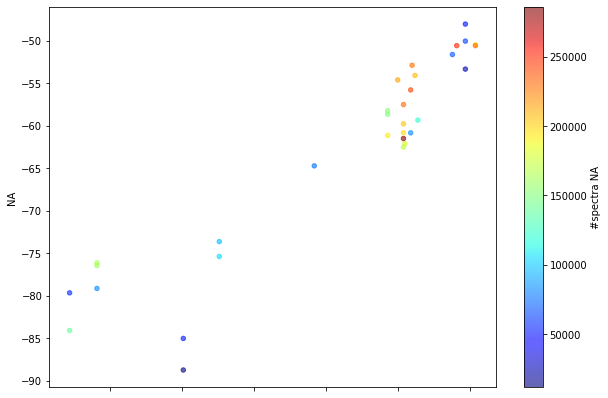

In [5]:
benchmarks1.plot(kind="scatter", x="IRMS", y="FFT", alpha=0.6, figsize=(10,7), c="#spectra FFT", 
                 cmap=plot.get_cmap("jet"))
benchmarks1.plot(kind="scatter", x="IRMS", y="NA", alpha=0.6, figsize=(10,7), c="#spectra NA", 
                 cmap=plot.get_cmap("jet"))

In [6]:
# final benchmarks community data

data2na = load_calisp_data('/home/kinestetika/Proteomics/mock-community/Run1_All/calisp/', target='na')
data2fft = load_calisp_data('/home/kinestetika/Proteomics/mock-community/Run1_All/calisp/', target='fft')
benchmarks2 = benchmark(data2na, data2fft)
print(f'community offset (na, fft) {benchmarks2["offset_NA"].mean():.1f}, {benchmarks2["offset_FFT"].mean():.1f}')
print(f'community error (na, fft) {benchmarks2["error_NA"].mean():.1f}, {benchmarks2["error_FFT"].mean():.1f}')

pd.set_option('precision', 1)
benchmarks2.style


Loaded 5149648 spectra from file(s). 2311271(44.9%) remaining after filters.
Loaded 5149648 spectra from file(s). 1088438(21.1%) remaining after filters.
community offset (na, fft) -16.8, -24.0
community error (na, fft) 12.8, 2.4


,file,bin,IRMS,#spectra NA,NA,#spectra FFT,FFT,offset_NA,offset_FFT,error_NA,error_FFT
0,,ATN,-23.8,136575,-33.3,51016,-47.3,-9.5,-23.5,7.3,0.5
1,,CRH,-30.8,164911,-51.2,105130,-60.3,-20.4,-29.5,3.6,5.6
2,,CV,-25.7,84323,-45.3,46097,-51.7,-19.6,-26.0,2.9,2.0
3,,Cup,-25.0,287834,-41.9,132060,-49.0,-16.9,-24.0,0.2,0.0
4,,K12,-24.5,302532,-48.8,183813,-49.8,-24.3,-25.3,7.5,1.3
5,,HOMO,-20.3,0,nan,0,nan,nan,nan,nan,nan
6,,Ne1,-47.8,550,-73.7,2166,-70.0,-25.9,-22.2,9.2,1.8
7,,Nu1,-39.9,756,-96.4,2395,-63.9,-56.5,-24.0,39.8,0.0
8,,NV,-37.4,31226,-57.3,13277,-65.7,-19.9,-28.3,3.1,4.3
9,,Nm1,-45.9,2123,-10.8,2725,-63.3,35.1,-17.4,51.9,6.6


<AxesSubplot:xlabel='IRMS', ylabel='NA'>

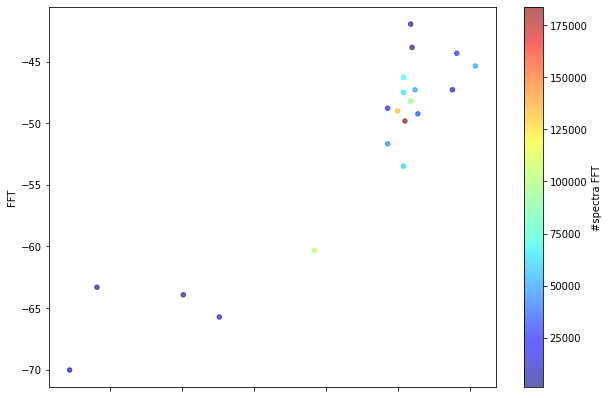

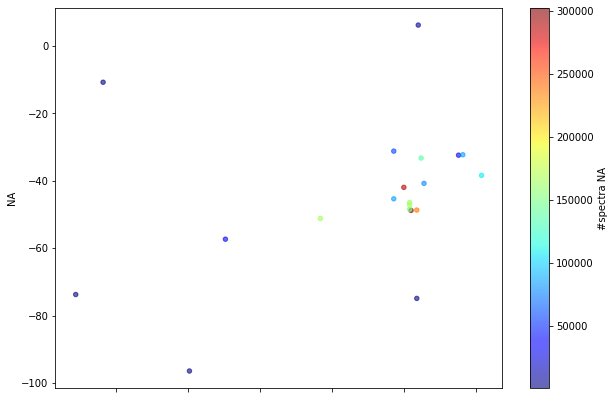

In [7]:
benchmarks2.plot(kind="scatter", x="IRMS", y="FFT", alpha=0.6, figsize=(10,7), c="#spectra FFT", 
                 cmap=plot.get_cmap("jet"))
benchmarks2.plot(kind="scatter", x="IRMS", y="NA", alpha=0.6, figsize=(10,7), c="#spectra NA", 
                 cmap=plot.get_cmap("jet"))
